- Tensorflow dataset
- Simple LSTM Network
- Long sequences to short chunks

In [1]:
! pip install pandas

    100% |████████████████████████████████| 10.0MB 223kB/s ta 0:00:01
    100% |████████████████████████████████| 512kB 168kB/s ta 0:00:01
You are using pip version 19.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
! pip install mne

    100% |████████████████████████████████| 6.6MB 841kB/s ta 0:00:011
    100% |████████████████████████████████| 26.0MB 592kB/s ta 0:00:01
You are using pip version 19.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
! pip install scikit-learn

    100% |████████████████████████████████| 7.0MB 1.9MB/s ta 0:00:011
    100% |████████████████████████████████| 296kB 3.3MB/s ta 0:00:01
You are using pip version 19.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
! pip install seaborn

    100% |████████████████████████████████| 225kB 3.0MB/s ta 0:00:01
You are using pip version 19.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
! pip install keras

    100% |████████████████████████████████| 378kB 1.2MB/s ta 0:00:011
    100% |████████████████████████████████| 276kB 390kB/s ta 0:00:01
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built pyyaml
You are using pip version 19.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
! pip install tqdm

    100% |████████████████████████████████| 61kB 698kB/s ta 0:00:011
You are using pip version 19.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import tensorflow as tf

In [2]:
import numpy as np

In [3]:
import pandas as pd

In [4]:
import mne

In [5]:
import os

In [6]:
import keras

Using TensorFlow backend.


In [7]:
import seaborn as sns

In [8]:
from collections import Counter

In [9]:
from tqdm import tqdm_notebook

In [10]:
from tqdm.notebook import tqdm

In [11]:
import matplotlib.pyplot as plt

Какие каналы содержат 

Dataset:
- Один сэмпл содержит чанк сигнала, чанки не пересекаются
- Считывание происходит из случайных файлов из списка
- Чанки рандомизированы:
    - Учесть рандомизацию по номеру пациента, сессии, времени

# Read labels

In [12]:
header = ["file", "start", "end", "label", "confidence"]
train_df = pd.read_csv("../_DOCS/ref_train.txt", sep=" ", names=header)
val_df = pd.read_csv("../_DOCS/ref_dev.txt", sep=" ", names=header)

In [13]:
def preprocess_file(full_file):
    parts = full_file.split("_")
    patient = int(parts[0])
    session = int(parts[1][1:])
    file = int(parts[2][1:])
    return [patient, session, file]

In [14]:
preprocess_file("00000258_s002_t000")

[258, 2, 0]

In [15]:
def append_file_info(df):
    values = np.array(df["file"].apply(preprocess_file).tolist())
    files_df = pd.DataFrame(values, columns=["patient", "session", "chunk"], index=df.index)
    return df.merge(files_df, how="inner", left_index=True, right_index=True)

In [16]:
train_df = append_file_info(train_df)

In [17]:
val_df = append_file_info(val_df)

# Attach files

TODO add other electrode formats

In [18]:
def attach_files(df, dataset):
    paths = {}

    for root, dirs, files in os.walk("../edf/{}".format(dataset)):
        path = root.split(os.sep)
        for file in files:
            if ".edf" in file:
                name = file.split(".")[0]
                paths[name] = os.path.abspath(root) + "/" +  file
    
    df["full_path"] = df["file"].apply(paths.get)
    return df[df["full_path"].apply(lambda x: "01_tcp_ar" in str(x))].copy()

In [19]:
train_df = attach_files(train_df, "train")

In [20]:
val_df = attach_files(val_df, "dev")

# Separate patients

In [21]:
train_patients = train_df["patient"].unique() 

In [22]:
val_patients = val_df["patient"].unique()

In [23]:
val_df = val_df[~val_df["patient"].isin(train_patients)].copy()

# Remove bckg files

In [24]:
def remove_bckg_files(df):
    files_with_seizures = df[df["label"] == "seiz"]["file"].unique()
    return df[df["file"].isin(files_with_seizures)].copy()

In [25]:
train_df = remove_bckg_files(train_df)

In [26]:
val_df = remove_bckg_files(val_df)

# Calculate channels intersection and proper sample rate

In [27]:
def get_edf_info(df):
    files = df["full_path"].unique()

    edf_data = []

    for file in tqdm_notebook(files):
        edf = mne.io.read_raw_edf(file, verbose="ERROR")
        data = {
            field: edf.info[field]
            for field in ["ch_names", "sfreq"]
        }
        edf_data.append(data)
        
    return pd.DataFrame(edf_data)

In [28]:
train_edf_df = get_edf_info(train_df)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [29]:
val_edf_df = get_edf_info(val_df)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [30]:
CHUNK_FREQUENCY = int(min(train_edf_df["sfreq"].min(), val_edf_df["sfreq"].min()))

In [31]:
counter = Counter([
    channel for channels_list in train_edf_df["ch_names"] for channel in channels_list
] + [
    channel for channels_list in val_edf_df["ch_names"] for channel in channels_list
])

In [32]:
all_channels = dict(counter.most_common())

In [33]:
usage_limit = max([v for k, v in all_channels.items() if "STI" not in k])
CHANNELS = [k for k, v in all_channels.items() if v >= usage_limit and "STI" not in k]

In [34]:
# STIM_CHANNEL = [k for k in all_channels.keys() if "STI" in k][0]

In [35]:
len(CHANNELS)

21

# Calculate chunk size

In [36]:
train_df["duration"] = train_df["end"] - train_df["start"]

label
bckg    AxesSubplot(0.125,0.125;0.775x0.755)
seiz    AxesSubplot(0.125,0.125;0.775x0.755)
Name: duration, dtype: object

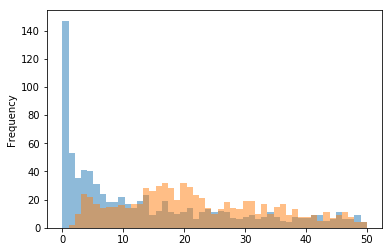

In [37]:
train_df.groupby('label')["duration"].plot(kind="hist", bins=np.linspace(0, 50), alpha=0.5)

In [38]:
CHUNK_TIME = 1 * CHUNK_FREQUENCY # number of terms per chunk

# Split on chunks

In [39]:
BATCH_SIZE = 32

- Get all file names, randomize them
- For each file - split on chunks, randomize them
- Get labels for each chunk

In [40]:
FFT_STEPS_NUM = 125

TODO:
- Fourier transform for chunk instead of full file

Как западить чанку нулями, и убрать их из лосса? Варианты:

### Удалять пустые чанки
3. Заменить в массиве data и events неполные чанки на зануленные
4. Добавить параметр mask, который отвечает за то, какие элементы функции потерь оставить
5. Заменить лосс


In [102]:
MAX_LENGTH = 100000

In [103]:
def get_fourier_transform(data, window_size=CHUNK_TIME, step_size=CHUNK_TIME // FFT_STEPS_NUM):
    frequencies = []
    for window in range(0, data.shape[0] - window_size, step_size):
        chunk = data[window:window + window_size]
        frequency_values = np.abs(np.fft.fft(chunk, axis=0))[:window_size // 2]
        frequencies.append(frequency_values)
    result = np.stack(frequencies)
    return result.reshape(result.shape[0], -1)

In [104]:
def get_data(df, file, channels=CHANNELS, chunk_size=CHUNK_TIME):
    annotations = df[
        (df["full_path"] == file) & \
        (df["label"] == "seiz")
    ][["start", "end"]]
    edf = mne.io.read_raw_edf(file, preload=True, verbose='ERROR')
    edf.filter(2, 60)
    edf_picks = edf.pick_channels(channels)
    data, time = edf_picks[:]
        
    events = time * 0
    for _, (start, end) in annotations.iterrows():
        events += (time >= start) & (time <= end)
    events = (events > 0).astype(int)
    
    return data, events

In [105]:
def get_data_multiple(df, files, channels=CHANNELS, chunk_size=CHUNK_TIME):
    total_data = []
    total_events = []
    for file in tqdm_notebook(files):
        data, events = get_data(df, file)
        total_data.append(data)
        total_events.append(events)
    
    return total_data, total_events

In [106]:
class ChunksIterator():
    def __init__(self, data, events, chunk_size=CHUNK_TIME, step_size=CHUNK_TIME // FFT_STEPS_NUM, max_length=MAX_LENGTH, tqdm_enabled=False):
        self.data = data
        self.events = events
        self.chunk_size = chunk_size
        self.step_size = step_size
        self.valid_chunks = 0
        
        max_time = min(max([e.shape[0] for e in events]), max_length)
        self.iterations = range(0, max_time - 2*chunk_size, chunk_size)
        self.iterations_number = len(self.iterations)
        if tqdm_enabled:
            self.iterations = tqdm(self.iterations)
        self.iterations = iter(self.iterations)
    
    def __iter__(self):
        return self
    
    def __next__(self):
        data = self.data
        events = self.events
        chunk_size = self.chunk_size
        step_size = self.step_size
        chunk_start = next(self.iterations)
        
        data_chunk = [d[:, chunk_start:chunk_start + 2*chunk_size].T for d in data]
        labels_chunk = [e[chunk_start:chunk_start + chunk_size] for e in events]

        zero_data_chunk = np.zeros((chunk_size * 2, len(CHANNELS)))
        zero_labels_chunk = np.zeros((chunk_size, ))

        masks_chunk = [e.shape[0] == chunk_size for e in labels_chunk]
        data_chunk = [d if d.shape[0] == 2*chunk_size else zero_data_chunk for d in data_chunk]
        labels_chunk = [e if e.shape[0] == chunk_size else zero_labels_chunk for e in labels_chunk]

        data_chunk = [get_fourier_transform(d) for d in data_chunk]
        labels_chunk = [e.reshape(step_size, -1).sum(axis=0) > 0 for e in labels_chunk]
        
        self.valid_chunks += sum(masks_chunk)

        return [np.stack(data_chunk), np.array(masks_chunk)], np.stack(labels_chunk)[:, :, np.newaxis]

In [107]:
# def iterate_chunks(data, events, chunk_size=CHUNK_TIME, step_size=CHUNK_TIME // FFT_STEPS_NUM, tqdm_enabled=False):
#     max_time = max([e.shape[0] for e in events])
#     while True:
#         iterations = range(0, max_time - 2*chunk_size, chunk_size)
#         if tqdm_enabled:
#             iterations = tqdm(iterations)
#         for chunk_start in iterations:
#             data_chunk = [d[:, chunk_start:chunk_start + 2*chunk_size].T for d in data]
#             labels_chunk = [e[chunk_start:chunk_start + chunk_size] for e in events]
            
#             zero_data_chunk = np.zeros((chunk_size * 2, len(CHANNELS)))
#             zero_labels_chunk = np.zeros((chunk_size, ))
            
#             masks_chunk = [e.shape[0] == chunk_size for e in labels_chunk]
#             data_chunk = [d if d.shape[0] == 2*chunk_size else zero_data_chunk for d in data_chunk]
#             labels_chunk = [e if e.shape[0] == chunk_size else zero_labels_chunk for e in labels_chunk]
            
#             data_chunk = [get_fourier_transform(d) for d in data_chunk]
#             labels_chunk = [e.reshape(step_size, -1).sum(axis=0) > 0 for e in labels_chunk]

#             yield [np.stack(data_chunk), np.array(masks_chunk)], np.stack(labels_chunk)[:, :, np.newaxis]

In [108]:
def iterate_files(df, batch_size=BATCH_SIZE):
    files = df["full_path"].unique()
    files = np.random.choice(files, len(files), replace=False)
    for files in zip(*[iter(files)]*batch_size):
        yield files

In [109]:
files = next(iterate_files(train_df))

In [110]:
data, events = get_data(train_df, files[0])

In [111]:
files = train_df["full_path"].value_counts().index[0:BATCH_SIZE]
data, events = get_data_multiple(train_df, files)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [112]:
partial_lengths = [int(d.shape[1] * 0.005) for d in data]
partial_data = [d[:, :l] for d, l in zip(data, partial_lengths)]
partial_events = [e[:l] for e, l in zip(events, partial_lengths)]
min(partial_lengths)

384

In [113]:
iterator = ChunksIterator(partial_data, partial_events, tqdm_enabled=True)

print("Total iterations:", iterator.iterations_number)

for i, ((data_chunk, masks_chunk), labels_chunk) in zip(range(10), iterator):
    print("Iteration {}".format(i), sum(masks_chunk))
    
print("Valid chunks:", iterator.valid_chunks)

Total iterations: 48
Iteration 0 32
Iteration 1 28
Iteration 2 27
Iteration 3 18
Iteration 4 16
Iteration 5 16
Iteration 6 10
Iteration 7 8
Iteration 8 6
Iteration 9 5
Valid chunks: 166


Чанк для LSTM: (BATCH_SIZE x CHUNK_TIME x FREQUENCIES * CHANNELS)

# Model creation

In [114]:
RNN_SIZE = 128
NUM_EPOCHS = 10

In [115]:
CNN_FILTERS = (8, 16, 32, 128)

In [116]:
HIDDEN_DIMS = (1024, 1024, 1024)

Можно ли добавить CNN?
- Conv1D: (BATCH_SIZE, CHUNK_TIME, CHANNELS) -> (BATCH_SIZE, CHUNK_TIME, CNN_FILTERS)
- MaxPool1D: (BATCH_SIZE, CHUNK_TIME, CNN_FILTERS) -> (BATCH_SIZE, CHUNK_TIME // POOL_SIZE, CNN_FILTERS)

Продолжать до тех пор, пока чанка не станет достаточного размера

In [117]:
import tensorflow as tf
from keras.layers import Dense,Activation,Dropout, Input
from keras.layers import LSTM,Bidirectional #could try TimeDistributed(Dense(...))
from keras.models import Sequential, load_model
from keras import optimizers,regularizers
from keras.layers.normalization import BatchNormalization
import keras.backend.tensorflow_backend as KTF

In [118]:
# model = Sequential()
# model.add(Dense(HIDDEN_DIMS[0], W_regularizer=regularizers.l2(l=0.01), batch_input_shape=(BATCH_SIZE, FFT_STEPS_NUM, CHUNK_TIME // 2 * len(CHANNELS))))
# model.add(Bidirectional(LSTM(RNN_SIZE, return_sequences=True, stateful=True)))#, input_shape=(seqlength, features)) ) ### bidirectional ---><---
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(Dense(HIDDEN_DIMS[1], activation='relu',W_regularizer=regularizers.l2(l=0.01)))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(Dense(1, activation='sigmoid'))

In [119]:
eeg_input = Input(batch_shape=(BATCH_SIZE, FFT_STEPS_NUM, CHUNK_TIME // 2 * len(CHANNELS)))

masks_input = Input(batch_shape=(BATCH_SIZE, 1))
squeezed_masks_input = tf.squeeze(masks_input)

x = Dense(
    HIDDEN_DIMS[0], 
    W_regularizer=regularizers.l2(l=0.01),
)(eeg_input)
x = Bidirectional(LSTM(RNN_SIZE, return_sequences=True, stateful=True))(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(HIDDEN_DIMS[1], activation='relu',W_regularizer=regularizers.l2(l=0.01))(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
events_output = Dense(1, activation='sigmoid')(x)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1024, kernel_regularizer=<keras.reg...)`
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1024, kernel_regularizer=<keras.reg..., activation="relu")`
  del sys.path[0]


In [120]:
model = keras.models.Model(inputs=[eeg_input, masks_input], outputs=[events_output])

In [121]:
s = tf.Session()

In [122]:
# a = data_chunk
# b = data_chunk
# c = [0] * 10 + [1] * 22
# binary_crossentropy_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=a, logits=b)
# masked_binary_crossentropy_loss = tf.boolean_mask(binary_crossentropy_loss, c, axis=0)
# s.run(masked_binary_crossentropy_loss).shape

In [123]:
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [ ]:
def masked_binary_crossentropy(y_true, y_pred):
    global squeezed_masks_input
    binary_crossentropy_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    masked_binary_crossentropy_loss = tf.boolean_mask(binary_crossentropy_loss, squeezed_masks_input, axis=0)
    return tf.reduce_mean(masked_binary_crossentropy_loss)

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [ ]:
model.compile(
    loss=masked_binary_crossentropy,
    optimizer='adam', 
    metrics=['accuracy', recall_m, precision_m]
)

# TODO Try to filter incomplete chunks

# Overfit on small dataset

TODO make model converge on this batch

In [ ]:
generator = ChunksIterator(data, events)

In [ ]:
for i in range(5):
    next(generator)
(x,  masks), y_end = next(generator)

In [ ]:
y_end.sum() / (y_end > -1).sum()

0.46875

In [ ]:
model.predict([x, masks]).mean()

0.4998581

In [ ]:
model.evaluate([x, masks], y_end)

32/32 [==============================] - 0s 12ms/step


[19.575618743896484, 0.53125, 0.0, 0.0]

In [ ]:
# model.fit(x, y_end, batch_size=x.shape[0], epochs=1000)

In [ ]:
y_end.sum()

1875

RNN использовать можно и даже немного нужно
А вот seq2seq не надо - у вас же одинаковая длина входа и выхода. Имплементация будет очень похожа не языковую модельку, как была в последней домашке.

Если это исследования, а не в прод катить, я бы попробовал LMU и LSTM-SHA из реккурентных и Sparse Transformer

# Train model

In [ ]:
train_history = []
val_history = []

for epoch in tqdm(range(10)):
    total_train_loss = 0
    total_train_chunks = 0
    
    total_val_loss = 0
    total_val_chunks = 0
    
    for train_files, val_files in tqdm_notebook(list(zip(iterate_files(train_df), iterate_files(val_df)))):
        # Training
        
        train_data, train_events = get_data_multiple(train_df, train_files)
        train_generator = ChunksIterator(train_data, train_events, tqdm_enabled=True)
        
        train_chunks = train_generator.iterations_number
        
        train_history = model.fit_generator(
            train_generator, 
            epochs=1, 
            steps_per_epoch=train_chunks,
        )
        
        total_train_loss += train_history.history['loss'][0] * train_generator.valid_chunks
        total_train_chunks += train_generator.valid_chunks
        
        model.reset_states()
        
        # Validation
        
        val_data, val_events = get_data_multiple(val_df, val_files)
        val_generator = ChunksIterator(val_data, val_events, tqdm_enabled=True)
        
        val_chunks = val_generator.iterations_number
        
        val_metrics = model.evaluate_generator(
            val_generator,
            steps=val_chunks
        )
        
        total_val_loss += val_metrics[0] * val_generator.valid_chunks
        total_val_chunks += val_generator.valid_chunks
        
        model.reset_states()
        
        print("Train loss:", total_train_loss / total_train_chunks)
        print("Val loss:", total_val_loss / total_val_chunks)
    
    train_history.append(total_train_loss / total_train_chunks)
    val_history.append(total_val_loss / total_val_chunks)
    model.save_weights("./models/lstm-fft-model-{}.h5".format(epoch))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Epoch 1/1
201/398 [==============>...............] - ETA: 2:41 - loss: 1.9613 - accuracy: 0.6898 - recall_m: 0.4380 - precision_m: 0.5693

# Проверено
- Участки с нулевым precision/recall - почему val и train одинаково содержат/не содержат нули? - удалены временно
- Влияет ли присутствие одинаковых пациентов/сессий в train/test? - разбиты на группы
- Файлы во всю длину, не учитывать loss - готово
- Собирать чанки tN файлов в один файл - не нужно пока что

# Проверить
- Модель переобучается, как можно ее уменьшить?
- Переименовывать каналы других интерфейсов - проверить различные интерфейсы на предмет соответствия каналов
- Влияние масштабирования сигнала 
- Можно ли использовать чанку большего размера? Можно ли ее предварительно сжать с помощью CNN? Как это повлияет на предсказание?
- Применима ли к данным фильтрация? моргания-движения/?
- Расстояние между приступами - не менее 3с, можно ли это использовать для сглаживания сегментов?

# Prediction

In [118]:
# val_files = next(iterate_files(val_df))

In [68]:
test_data, test_events = get_data_multiple(train_df, train_files)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [69]:
class TestGenerator():
    def __init__(self, data, events):
        self.events = []
        self.generator = iterate_chunks(data, events, tqdm_enabled=True)
    
    def __iter__(self):
        return self
    
    def __next__(self):
        data_chunk, events_chunk = next(self.generator)
        self.events.append(events_chunk)
        return data_chunk, events_chunk

In [70]:
model.reset_states()

test_generator = TestGenerator(train_data, train_events)

In [71]:
number_of_chunks(test_events.shape[1])

13

In [72]:
test_events.shape[1]

3750

In [73]:
prediction = model.predict_generator(
    test_generator,
    number_of_chunks(test_events.shape[1])
)

In [77]:
all_true_events = np.stack(test_generator.events[:-1])

In [78]:
all_predicted_events = prediction.reshape(*all_true_events.shape)

In [79]:
(all_true_events > 0.5).sum() / (all_true_events > -1).sum()

0.0

In [81]:
all_predicted_events[all_true_events > 0.5].mean()

array([], dtype=float32)

In [ ]:
all_predicted_events[all_true_events < 0.5].mean()

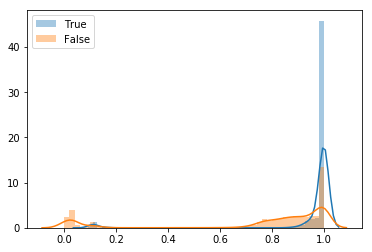

In [113]:
sns.distplot(all_predicted_events[all_true_events > 0.5], label="True")
sns.distplot(all_predicted_events[all_true_events < 0.5], label="False")
plt.legend()

In [121]:
true_events_line = all_true_events[:, 0, :, :].reshape(-1)

In [122]:
predicted_events_line = all_predicted_events[:, 0, :, :].reshape(-1)

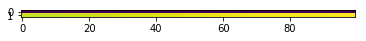

In [129]:
plt.plot(true_events_line)
plt.plot(predicted_events_line)

TODO

In time

# Compare focal loss params

In [602]:
def np_focal_loss(y_true, y_pred, gamma, alpha):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    p1 = y_pred[(y_true > 0.5)]
    p0 = y_pred[(y_true < 0.5)]
    p1_mean = - np.sum(alpha * ((1 - p1) ** gamma) * np.log(p1))
    p0_mean = - np.sum((1 - alpha) * (p0 ** gamma) * np.log(1 - p0))
    return (p1_mean + p0_mean) / y_true.shape[0]

In [603]:
shape = 1000
y_true = (np.random.rand(shape) < 0.3).astype(float)
y_pred_1 = 0.5 * np.ones(y_true.shape)
y_pred_2 = 0.1 * np.ones(y_true.shape) # Should be greater than 1
y_pred_3 = 0.49 * np.ones(y_true.shape) + (y_true > 0.5) * (0.9 - 0.49) # Should be less than 1
y_pred_4 = 0.99 * np.ones(y_true.shape) # Should be greater than 1

In [604]:
gamma = 1
alpha = 0.5

In [605]:
np_focal_loss(y_true, y_pred_1, gamma=gamma, alpha=alpha)

0.17328679513998635

In [606]:
np_focal_loss(y_true, y_pred_2, gamma=gamma, alpha=alpha)

0.3279382440610576

In [607]:
np_focal_loss(y_true, y_pred_3, gamma=gamma, alpha=alpha)

0.11498288055263572

In [608]:
np_focal_loss(y_true, y_pred_4, gamma=gamma, alpha=alpha)

1.5660729280736512

# Prepare small MLP classifier

In [813]:
generator = iterate_chunks(data, events)

In [814]:
next(generator)
x, y = next(generator)

In [815]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

In [862]:
model = MLPClassifier(hidden_layer_sizes=(100, 100, 100, 100), solver="adam")

In [863]:
new_y = (np.squeeze(y).mean(axis=1) > 0.5)

In [864]:
new_y.sum() / new_y.shape[0]

0.375

In [865]:
new_x = x.reshape(32, 250 * 21)

In [866]:
model.fit(new_x, new_y)

/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100, 100, 100), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [867]:
model.score(new_x, new_y)

1.0

# Seq2seq

In [ ]:
feature_extractor = eeg_input

for cnn_filters in CNN_FILTERS:
    feature_extractor = keras.layers.Conv1D(cnn_filters, kernel_size=3, padding="same", activation="relu")(feature_extractor)
    feature_extractor = keras.layers.Conv1D(cnn_filters, kernel_size=3, padding="same", activation="relu")(feature_extractor)
    feature_extractor = keras.layers.MaxPool1D(pool_size=2, padding="same")(feature_extractor)

In [ ]:
encoder_outputs, encoder_h_state, encoder_c_state = keras.layers.LSTM(RNN_SIZE, stateful=True, return_state=True)(feature_extractor)

events_input = keras.layers.Input(batch_shape=(BATCH_SIZE, CHUNK_TIME, 1), name="events")

decoder_outputs, _, _ = keras.layers.LSTM(RNN_SIZE, return_sequences=True, return_state=True)(
    events_input, 
    initial_state=[encoder_h_state, encoder_c_state]
)
decoder_outputs = keras.layers.Dense(1, activation='sigmoid')(decoder_outputs)

model = keras.models.Model(inputs=[eeg_input, events_input], outputs=[decoder_outputs])

# One sequence

In [ ]:
# import tensorflow as tf
# from keras.layers import Dense,Activation,Dropout
# from keras.layers import LSTM,Bidirectional #could try TimeDistributed(Dense(...))
# from keras.models import Sequential, load_model
# from keras import optimizers,regularizers
# from keras.layers.normalization import BatchNormalization
# import keras.backend.tensorflow_backend as KTF

# model = Sequential()
# model.add(Dense(32,W_regularizer=regularizers.l2(l=0.01), batch_input_shape=(BATCH_SIZE, CHUNK_TIME // 2, len(CHANNELS))))
# model.add(Bidirectional(LSTM(32, return_sequences=True, stateful=True)))#, input_shape=(seqlength, features)) ) ### bidirectional ---><---
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(Dense(64, activation='relu',W_regularizer=regularizers.l2(l=0.01)))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(Dense(1, activation='sigmoid'))

In [ ]:
# def focal_loss(gamma=0, alpha=0.5):
#     def focal_loss_fixed(y_true, y_pred):
#         pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
#         pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
#         total_sum = - K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) 
#         total_sum -= K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
#         return 2 * total_sum / tf.cast(K.size(y_true), dtype=tf.float32)
#     return focal_loss_fixed